In [2]:
import yfinance as yf
import vectorbt as vbt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from numba import njit
vbt.settings.set_theme('dark')
plt.style.use('dark_background')


In [ ]:

pd.set_option('display.max_columns', None)


df = pd.read_csv(r"C:\Users\Jordi\Desktop\ALGO\algo\aggregated_2024_600_ticks.csv")

mean_std1Down = 0.5449512453059433  
mean_std1Up = 0.5338575213036608    


df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date
unique_dates = df['Date'].unique()
print(unique_dates)

vix = yf.download('^VIX', start='2022-01-01', end='2024-10-10', interval='1d')
vix.reset_index(inplace=True)
vix = vix[['Date', 'Open']].copy() 
vix.rename(columns={'Open': 'VIX_Open'}, inplace=True)
vix['Date'] = vix['Date'].dt.date

result = pd.DataFrame(unique_dates, columns=['Date'])
result = result.merge(vix[['Date', 'VIX_Open']], on='Date', how='left')


df_first_open_close = df.groupby('Date').agg({'open': 'first', 'close': 'last'}).reset_index()


result = result.merge(df_first_open_close[['Date', 'open', 'close']], on='Date', how='left')


result.rename(columns={'open': 'SP_Open', 'close': 'SP_Close'}, inplace=True)


result['STD1_up'] = (result['VIX_Open'] / np.sqrt(252) + mean_std1Up) / 2
result['STD2_up'] = result['STD1_up'] * 2
result['STD3_up'] = result['STD1_up'] * 3

result['STD1_down'] = (result['VIX_Open'] / np.sqrt(252) + mean_std1Down) / 2
result['STD2_down'] = result['STD1_down'] * 2
result['STD3_down'] = result['STD1_down'] * 3


result['STD1_up'] = (result['STD1_up'] * result['SP_Open'] / 100) + result['SP_Open']
result['STD2_up'] = (result['STD2_up'] * result['SP_Open'] / 100) + result['SP_Open']
result['STD3_up'] = (result['STD3_up'] * result['SP_Open'] / 100) + result['SP_Open']

result['STD1_down'] = result['SP_Open'] - (result['STD1_down'] * result['SP_Open'] / 100)
result['STD2_down'] = result['SP_Open'] - (result['STD2_down'] * result['SP_Open'] / 100)
result['STD3_down'] = result['SP_Open'] - (result['STD3_down'] * result['SP_Open'] / 100)


df_high_low = df.groupby('Date').agg({'high': 'max', 'low': 'min'}).reset_index()
result = result.merge(df_high_low, on='Date', how='left')


freqs = {
    'STD1_down_to_STD2_down': 0,
    'STD2_down_to_STD3_down': 0,
    'STD1_up_to_STD2_up': 0,
    'STD2_up_to_STD3_up': 0,
}

mean_reverse = {
    'rebondstd2': 0,
    'rebondstd3': 0,
    'deepstd2': 0,
    'deepstd3': 0,

}


for index, row in result.iterrows():
    low = row['low']
    high = row['high']

    if row['STD2_down'] <= low < row['STD1_down']:
        freqs['STD1_down_to_STD2_down'] += 1
        mean_reverse['rebondstd2'] =  ((row['SP_Close'] - low) * 4) / freqs['STD1_down_to_STD2_down']
    elif row['STD3_down'] <= low < row['STD2_down']:
        freqs['STD2_down_to_STD3_down'] += 1
        mean_reverse['rebondstd3'] =  ((row['SP_Close'] - low) * 4) / freqs['STD2_down_to_STD3_down']

    if row['STD1_up'] < high <= row['STD2_up']:
        freqs['STD1_up_to_STD2_up'] += 1
        mean_reverse['deepstd2'] =  ((high - row['SP_Close']) * 4) / freqs['STD1_up_to_STD2_up']
    elif row['STD2_up'] < high <= row['STD3_up']:
        freqs['STD2_up_to_STD3_up'] += 1

        mean_reverse['deepstd3'] =  ((high - row['SP_Close']) * 4) / freqs['STD2_up_to_STD3_up']






def detect_crossover(row):
    if row['EMA_15'] > row['EMA_30']:
        return 'Bull'
    elif row['EMA_15'] < row['EMA_30']:
        return 'Bear'
    else:
        return 'Neutre'




df['EMA_30']= df['open'].rolling(window=1500).mean()
df['EMA_60']= df['open'].rolling(window=3000).mean()


def detect_crossover(row):
    if row['EMA_30'] > row['EMA_60']:
        return 'Bull'
    elif row['EMA_30'] < row['EMA_60']:
        return 'Bear'
    else:
        return 'Neutre'

df['Crossover'] = df.apply(detect_crossover, axis=1)



print(mean_reverse['deepstd3'])
df = df.merge(result[['Date', 'STD1_up', 'STD2_up', 'STD3_up', 'STD1_down', 'STD2_down', 'STD3_down']], 
              on='Date', how='left')



[datetime.date(2024, 1, 1) datetime.date(2024, 1, 2)
 datetime.date(2024, 1, 3) datetime.date(2024, 1, 4)
 datetime.date(2024, 1, 5) datetime.date(2024, 1, 8)
 datetime.date(2024, 1, 9) datetime.date(2024, 1, 10)
 datetime.date(2024, 1, 11) datetime.date(2024, 1, 12)
 datetime.date(2024, 1, 15) datetime.date(2024, 1, 16)
 datetime.date(2024, 1, 17) datetime.date(2024, 1, 18)
 datetime.date(2024, 1, 19) datetime.date(2024, 1, 22)
 datetime.date(2024, 1, 23) datetime.date(2024, 1, 24)
 datetime.date(2024, 1, 25) datetime.date(2024, 1, 26)
 datetime.date(2024, 1, 29) datetime.date(2024, 1, 30)
 datetime.date(2024, 1, 31) datetime.date(2024, 2, 1)
 datetime.date(2024, 2, 2) datetime.date(2024, 2, 5)
 datetime.date(2024, 2, 6) datetime.date(2024, 2, 7)
 datetime.date(2024, 2, 8) datetime.date(2024, 2, 9)
 datetime.date(2024, 2, 12) datetime.date(2024, 2, 13)
 datetime.date(2024, 2, 14) datetime.date(2024, 2, 15)
 datetime.date(2024, 2, 16) datetime.date(2024, 2, 19)
 datetime.date(2024, 2, 

[*********************100%%**********************]  1 of 1 completed


3.3333333333333335


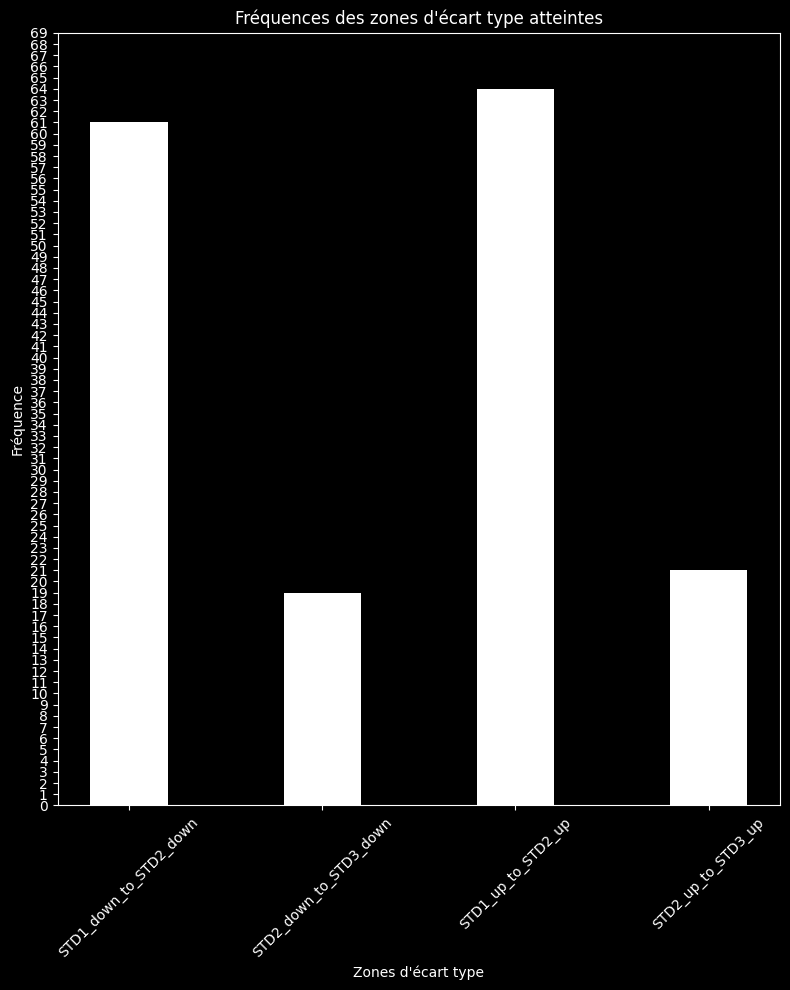

In [98]:
labels = list(freqs.keys()) 
values = list(freqs.values())  

plt.figure(figsize=(8, 10))  
plt.bar(labels, values, color=['white', 'white', 'white', 'white'], width=0.4)  
plt.title('Fréquences des zones d\'écart type atteintes') 
plt.xlabel('Zones d\'écart type') 
plt.ylabel('Fréquence')  
plt.xticks(rotation=45)  

plt.yticks(np.arange(0, 70, 1))  
plt.tight_layout()  
plt.show()


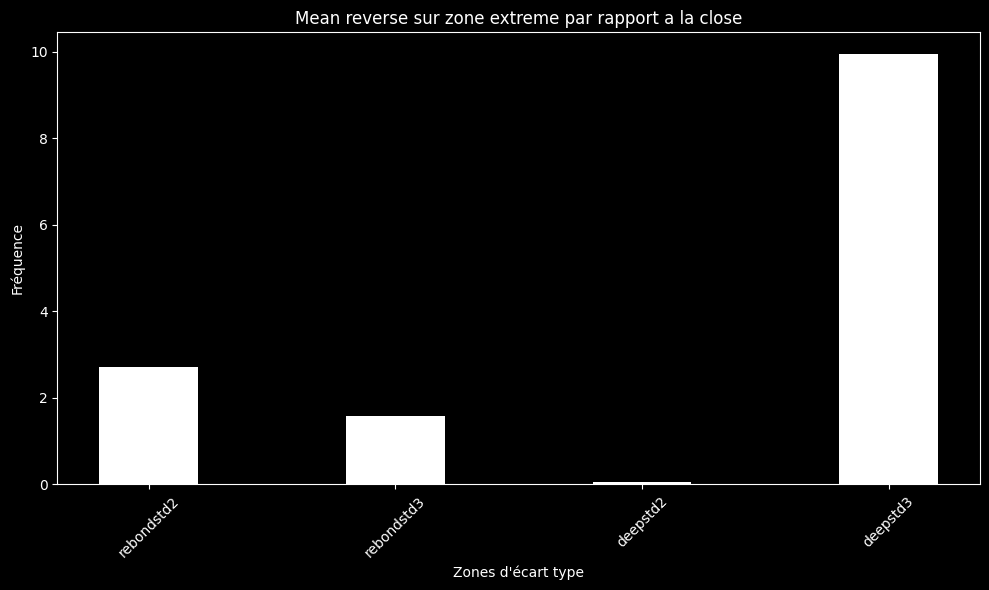

In [99]:
labels = list(mean_reverse.keys()) 
values = list(mean_reverse.values())  

plt.figure(figsize=(10, 6))  
plt.bar(labels, values, color=['white', 'white', 'white', 'white'], width=0.4)  
plt.title('Mean reverse sur zone extreme par rapport a la close') 
plt.xlabel('Zones d\'écart type') 
plt.ylabel('Fréquence')  
plt.xticks(rotation=45)  

 
plt.tight_layout()  
plt.show()




On peut voir pour l'instant c'est un visu tout a fait primaire mais par exemple quand on a une tendance fortement prononcer et que on va faire un extreme opposer a la tendance on aura tendance a faire des gros reverse derrière


In [3]:
#Mon idée va etre assez simple quand on arrive sur les zones d"écart type intéréssante, avec mon CVD je vais avoir une moyenne glissante du delta sur les 20 dernieres bougie quand je vois
#un delta qui viens ce reverse alors je rentre en position 

df['rolling_mean'] =  df['delta'].rolling(window=50).mean()

# Quand je suis dans une zone d'excès je vais chercher un cross CVD Dans le sens de mon trade rentrer en position et chercher une amplitude de 1 pour 1






In [5]:
def mean_reversion(market):
    takeposition = 0
    positions = []
    date_actuel = market.iloc[0]['Date']  # Date is a reference to avoid taking more than one trade
    for index, row in market.iloc[:-1].iterrows():
        # When I take a position, I block the possibility of taking another one. This is a choice that can change.
        date = row['Date']
        if date != date_actuel:
            date_actuel = date
            takeposition = 0
        if takeposition != 1:
            if row['Crossover'] == "Bull":
                if (row['close'] < row['STD2_down'] and row['close'] > row['STD3_down']):
                    if market['rolling_mean'].iloc[index - 1] < 0 and row['rolling_mean'] > 0:
                        new_position = {
                            'side': 'long',
                            'entry_price': row['close'],
                            'stop_loss': row['close'] - 40,
                            'tp': row['close'] + 80,
                            'date': row['Date'],
                            'index': index,
                            'type': "std2/std3",
                        }
                        positions.append(new_position)
                        takeposition = 1

                if (row['close'] < row['STD1_down'] and row['close'] > row['STD2_down']):
                    if market['rolling_mean'].iloc[index - 1] < 0 and row['rolling_mean'] > 0:
                        new_position = {
                            'side': 'long',
                            'entry_price': row['close'],
                            'stop_loss': row['close'] - 80,
                            'tp': row['close'] + 80,
                            'date': row['Date'],
                            'index': index,
                            'type': "std1/std2",
                        }
                        positions.append(new_position)
                        takeposition = 1

            if row['Crossover'] == "ear":
                if (row['close'] < row['STD2_up'] and row['close'] > row['STD1_up']):
                    if market['rolling_mean'].iloc[index - 1] > 0 and row['rolling_mean'] < 0:
                        new_position = {
                            'side': 'short',
                            'entry_price': row['close'],
                            'stop_loss': row['close'] + 80,
                            'tp': row['close'] - 80,
                            'date': row['Date'],
                            'index': index,
                        }
                        positions.append(new_position)
                        takeposition = 1

                if (row['close'] < row['STD3_up'] and row['close'] > row['STD2_up']):
                    if market['rolling_mean'].iloc[index - 1] > 0 and row['rolling_mean'] < 0:
                        new_position = {
                            'side': 'short',
                            'entry_price': row['close'],
                            'stop_loss': row['close'] + 80,
                            'tp': row['close'] - 80,
                            'date': row['Date'],
                            'index': index,
                        }
                        positions.append(new_position)
                        takeposition = 1

    return positions

positions = mean_reversion(df)
for position in positions:
    print(position)

{'side': 'long', 'entry_price': 4761.5, 'stop_loss': 4681.5, 'tp': 4841.5, 'date': datetime.date(2024, 1, 17), 'index': 4306, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 4888.25, 'stop_loss': 4808.25, 'tp': 4968.25, 'date': datetime.date(2024, 1, 31), 'index': 8060, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 4988.0, 'stop_loss': 4908.0, 'tp': 5068.0, 'date': datetime.date(2024, 2, 13), 'index': 10973, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 5095.5, 'stop_loss': 5015.5, 'tp': 5175.5, 'date': datetime.date(2024, 3, 5), 'index': 16327, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 5245.25, 'stop_loss': 5165.25, 'tp': 5325.25, 'date': datetime.date(2024, 4, 2), 'index': 19065, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 5237.75, 'stop_loss': 5157.75, 'tp': 5317.75, 'date': datetime.date(2024, 4, 4), 'index': 19928, 'type': 'std1/std2'}
{'side': 'long', 'entry_price': 5099.75, 'stop_loss': 5019.75, 'tp': 5179.75, 'date': datetime.date(2024, 4,

In [117]:

def backtest(market, positions):
    results = []
    capital=100000
    risk = 5
    point_value_per_contract = 5

    
    for pos in positions:
        entry_date = pos['date']
        side = pos['side']

        entry_price = pos['entry_price']
        stop_loss = pos['stop_loss']
        tp = pos['tp']
        index_candle= pos['index']
        trade_outcome = None


        for index, row in market.iloc[index_candle:].iterrows():

            date=row['Date']
            

            
            if side == 'long':


                if row['low'] <= stop_loss:
                    trade_outcome = 'stop_loss'
                    exit_price = stop_loss
                    break

                elif row['high'] >=  tp :
                    trade_outcome = 'take_profit'
                    exit_price = tp
                    break
                    
                        

            elif side == 'short':


                if row['high'] >= stop_loss:
                    trade_outcome = 'stop_loss'
                    exit_price = stop_loss
                    break

                elif row['low'] <= tp :
                    trade_outcome = 'take_profit'
                    exit_price = tp
                    break
               
       

        points_moved = (exit_price - entry_price) if side == 'long' else (entry_price - exit_price)
        return_amount = points_moved * point_value_per_contract * risk


        result = {
            'entry_date': entry_date,
            'side': side,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'trade_outcome': trade_outcome,
            'return_amount': return_amount,

        }
        results.append(result)
    
    return pd.DataFrame(results)

result = backtest(df,positions)
def highlight_rows(row):
    color = 'background-color: green' if row['side'] == 'long' else 'background-color: red'
    return [color] * len(row)

styled_result = result.style.apply(highlight_rows, axis=1)

# Afficher le DataFrame stylisé
styled_result

,entry_date,side,entry_price,exit_price,trade_outcome,return_amount
0,2022-02-10,long,4527.000000,4447.000000,stop_loss,-2000.000000
1,2022-02-15,short,4452.500000,4372.500000,take_profit,2000.000000
2,2022-02-17,long,4410.000000,4330.000000,stop_loss,-2000.000000
3,2022-02-22,short,4329.500000,4249.500000,take_profit,2000.000000
4,2022-03-01,long,4312.000000,4392.000000,take_profit,2000.000000
5,2022-03-02,short,4390.000000,4310.000000,take_profit,2000.000000
6,2022-03-04,long,4311.250000,4231.250000,stop_loss,-2000.000000
7,2022-03-08,short,4246.500000,4166.500000,take_profit,2000.000000
8,2022-03-09,short,4236.250000,4316.250000,stop_loss,-2000.000000
9,2022-03-16,short,4300.000000,4380.000000,stop_loss,-2000.000000


En réalité comme prévue l'utilisation des extreme comme ici doit etre plus subtil avec plus d'info.. Je veux aller trop vite déja la choses a faire c'est j'aimerais mettre une crois sur tout les endroits ou je prend position

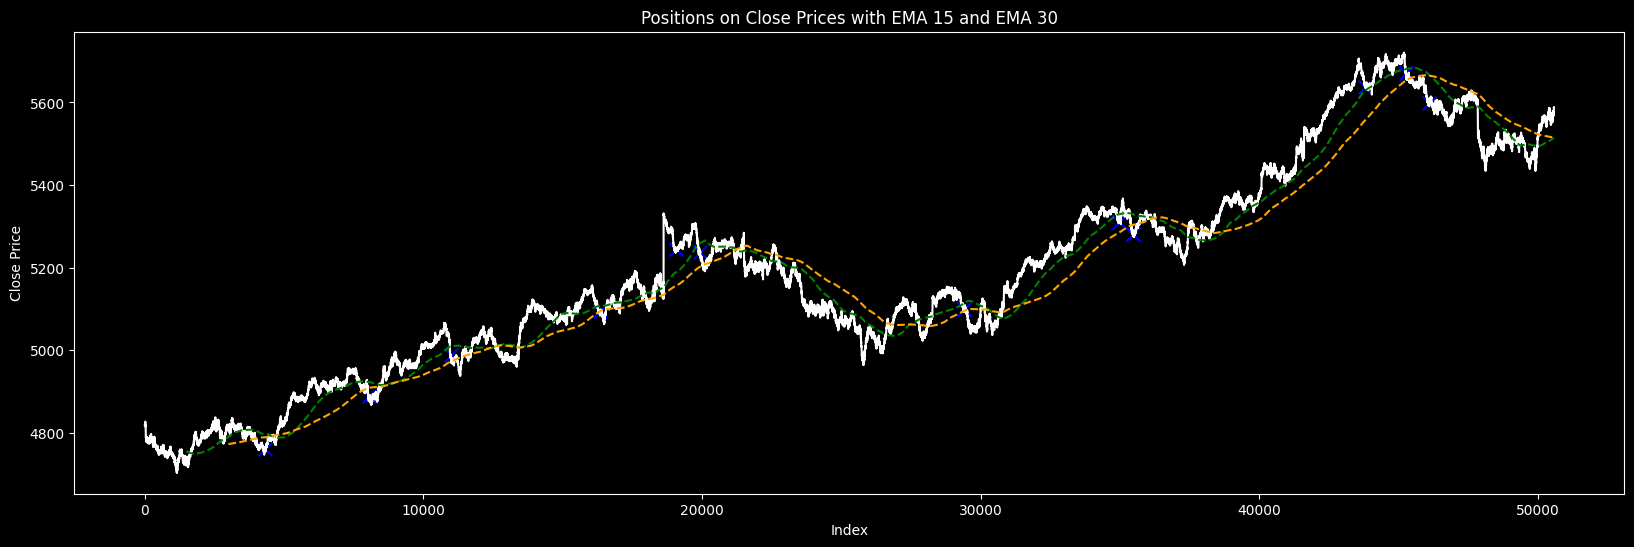

In [6]:
close_prices = df['close']
ema_15 = df['EMA_30']
ema_30 = df['EMA_60']
index_values = df.index  # Utiliser l'index comme valeurs pour l'axe x

# Créer la figure
plt.figure(figsize=(20, 6))

# Tracer les prix de clôture
plt.plot(index_values, close_prices, label='Close Prices', color='white')

# Tracer les EMA 15 et EMA 30
plt.plot(index_values, ema_15, label='EMA 15', color='green', linestyle='--')
plt.plot(index_values, ema_30, label='EMA 30', color='orange', linestyle='--')

# Boucle sur les positions pour ajouter les croix
for position in positions:
    position_index = position['index']
    position_type = position['side']
    
    # Vérifier le type de position et ajouter la croix
    if position_type == 'long':
        plt.scatter(position_index, df['close'].iloc[position_index], marker='x', color='blue', s=100, label='Long Position' if 'Long Position' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif position_type == 'short':
        plt.scatter(position_index, df['close'].iloc[position_index], marker='x', color='red', s=100, label='Short Position' if 'Short Position' not in plt.gca().get_legend_handles_labels()[1] else "")


# Ajouter les étiquettes et la légende
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Positions on Close Prices with EMA 15 and EMA 30')



# Afficher le graphique
plt.show()

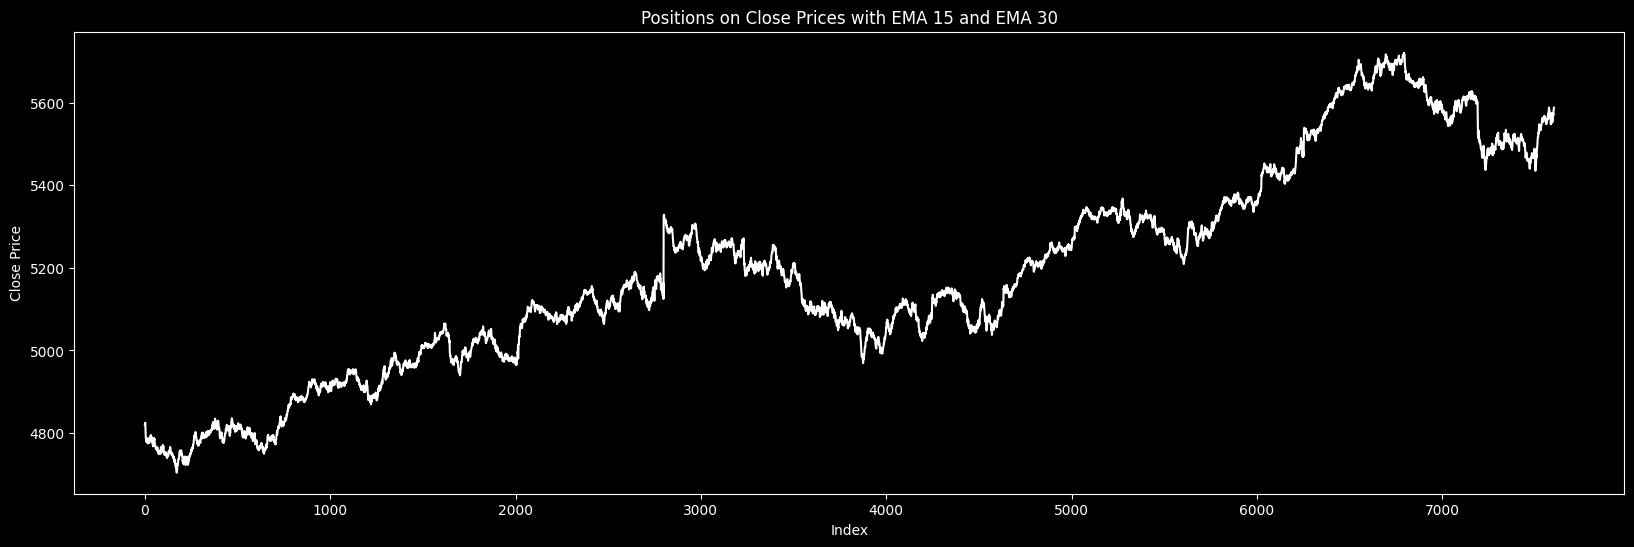

In [10]:
df2 = pd.read_csv(r"C:\Users\Jordi\Desktop\ALGO\algo\aggregated_2024_4000_ticks.csv")

close_prices = df2['close']

index_values = df2.index  # Utiliser l'index comme valeurs pour l'axe x

plt.figure(figsize=(20, 6))

# Tracer les prix de clôture
plt.plot(index_values, close_prices, label='Close Prices', color='white')



plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Positions on Close Prices with EMA 15 and EMA 30')

plt.show()

Pour la suite du code Objectif :
    -> Coder un indicateur de mean reversion
    -> Prendre les trades seulement quand les conditions de mean reversion sont validé 
